In [1]:
START_DATE = "02/29/2020"
END_DATE = "05/30/2020"
TRAIN_SPLIT_IDX = 60
TIME_WINDOW_SIZE = 7
DS_LABEL = "test_gen"

In [2]:
import random
import torch
import math
import pandas as pd
import pathlib


def getDateRange(start, end):
    start_date  = pd.to_datetime(start)
    end_date    = pd.to_datetime(end)
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    return dates

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# by borough

death_df = pd.read_csv("https://raw.githubusercontent.com/nychealth/coronavirus-data/master/trends/deaths-by-day.csv")
case_df = pd.read_csv("https://raw.githubusercontent.com/nychealth/coronavirus-data/master/trends/cases-by-day.csv")

death_df['date_of_interest'] = pd.to_datetime(death_df['date_of_interest'])
case_df['date_of_interest'] = pd.to_datetime(case_df['date_of_interest'])

In [4]:
BOROUGH_FIPS_MAP = {
    'BX' : 36005,
    'BK' : 36047,
    'MN' : 36061,
    'QN' : 36081,
    'SI' : 36085,
}

In [5]:
subset_cols = ['date_of_interest', 'BX_DEATH_COUNT', 'BX_DEATH_COUNT_7DAY_AVG',
       'BK_DEATH_COUNT', 'BK_DEATH_COUNT_7DAY_AVG', 'MN_DEATH_COUNT',
       'MN_DEATH_COUNT_7DAY_AVG', 'QN_DEATH_COUNT', 'QN_DEATH_COUNT_7DAY_AVG',
       'SI_DEATH_COUNT', 'SI_DEATH_COUNT_7DAY_AVG']
death_subset_df = death_df.loc[(START_DATE <= death_df['date_of_interest']) & (death_df['date_of_interest'] <= END_DATE), subset_cols]
death_subset_df = pd.melt(death_subset_df, id_vars=['date_of_interest'])
death_subset_df[['borough', 'metric']] = death_subset_df['variable'].str.split('_', n=1, expand=True)
death_subset_df = death_subset_df.pivot(index=['date_of_interest','borough'], columns='metric', values='value').reset_index()

death_subset_df['FIPS'] = death_subset_df['borough'].map(BOROUGH_FIPS_MAP)

death_subset_df['node_key'] = death_subset_df['date_of_interest'].astype('str') + "-" + death_subset_df['FIPS'].astype(str)
long_cols = ['date_of_interest', 'FIPS', 'node_key', 'DEATH_COUNT', 'DEATH_COUNT_7DAY_AVG']
death_subset_df = death_subset_df[long_cols]
death_subset_df.head()

metric,date_of_interest,FIPS,node_key,DEATH_COUNT,DEATH_COUNT_7DAY_AVG
0,2020-02-29,36047,2020-02-29-36047,0,0
1,2020-02-29,36005,2020-02-29-36005,0,0
2,2020-02-29,36061,2020-02-29-36061,0,0
3,2020-02-29,36081,2020-02-29-36081,0,0
4,2020-02-29,36085,2020-02-29-36085,0,0


In [6]:
# compute deltas
death_subset_df = death_subset_df.sort_values(by=['date_of_interest', 'FIPS'])

death_subset_df['DEATH_DELTA'] = death_subset_df.groupby(['FIPS'])['DEATH_COUNT'].diff(-1).fillna(0)
death_subset_df['DEATH_DELTA'] = death_subset_df['DEATH_DELTA'] * -1


In [7]:
subset_cols = ['date_of_interest',
               'BX_CASE_COUNT', 'BX_CASE_COUNT_7DAY_AVG',
               'BK_CASE_COUNT', 'BK_CASE_COUNT_7DAY_AVG',
               'MN_CASE_COUNT', 'MN_CASE_COUNT_7DAY_AVG',
               'QN_CASE_COUNT', 'QN_CASE_COUNT_7DAY_AVG',
               'SI_CASE_COUNT', 'SI_CASE_COUNT_7DAY_AVG']
case_subset_df = case_df.loc[(START_DATE <= case_df['date_of_interest']) & (case_df['date_of_interest'] <= END_DATE), subset_cols]
case_subset_df = pd.melt(case_subset_df, id_vars=['date_of_interest'])
case_subset_df[['borough', 'metric']] = case_subset_df['variable'].str.split('_', n=1, expand=True)
case_subset_df = case_subset_df.pivot(index=['date_of_interest','borough'], columns='metric', values='value').reset_index()

case_subset_df['FIPS'] = case_subset_df['borough'].map(BOROUGH_FIPS_MAP)
case_subset_df['node_key'] = case_subset_df['date_of_interest'].astype('str') + "-" + case_subset_df['FIPS'].astype(str)
long_cols = ['date_of_interest', 'FIPS', 'node_key', 'CASE_COUNT', 'CASE_COUNT_7DAY_AVG']

case_subset_df = case_subset_df[long_cols]
case_subset_df.head()

metric,date_of_interest,FIPS,node_key,CASE_COUNT,CASE_COUNT_7DAY_AVG
0,2020-02-29,36047,2020-02-29-36047,0,0
1,2020-02-29,36005,2020-02-29-36005,0,0
2,2020-02-29,36061,2020-02-29-36061,1,0
3,2020-02-29,36081,2020-02-29-36081,0,0
4,2020-02-29,36085,2020-02-29-36085,0,0


In [8]:
# compute deltas
case_subset_df = case_subset_df.sort_values(by=['date_of_interest', 'FIPS'])

case_subset_df['CASE_DELTA'] = case_subset_df.groupby(['FIPS'])['CASE_COUNT'].diff(-1).fillna(0)
case_subset_df['CASE_DELTA'] = case_subset_df['CASE_DELTA'] * -1
case_subset_df.loc[case_subset_df.FIPS == 36005]

metric,date_of_interest,FIPS,node_key,CASE_COUNT,CASE_COUNT_7DAY_AVG,CASE_DELTA
1,2020-02-29,36005,2020-02-29-36005,0,0,-0.0
6,2020-03-01,36005,2020-03-01-36005,0,0,-0.0
11,2020-03-02,36005,2020-03-02-36005,0,0,-0.0
16,2020-03-03,36005,2020-03-03-36005,0,0,-0.0
21,2020-03-04,36005,2020-03-04-36005,0,0,-0.0
...,...,...,...,...,...,...
436,2020-05-26,36005,2020-05-26-36005,283,188,-99.0
441,2020-05-27,36005,2020-05-27-36005,184,175,-65.0
446,2020-05-28,36005,2020-05-28-36005,119,163,45.0
451,2020-05-29,36005,2020-05-29-36005,164,149,-82.0


In [9]:
dates = getDateRange(START_DATE, END_DATE)
fips_list = list(BOROUGH_FIPS_MAP.values())

node_dict = dict()

curr_idx = 0
for f in fips_list:
    for d in dates:
        key_str = f"{f}-{d.strftime('%Y-%m-%d')}"
        node_dict[key_str] = curr_idx
        curr_idx += 1

pd.DataFrame.from_dict(node_dict, orient='index')

,0
36005-2020-02-29,0
36005-2020-03-01,1
36005-2020-03-02,2
36005-2020-03-03,3
36005-2020-03-04,4
...,...
36085-2020-05-26,455
36085-2020-05-27,456
36085-2020-05-28,457
36085-2020-05-29,458


In [10]:
deltaT = pd.Timedelta(value=1, unit="D") 

for f in list(BOROUGH_FIPS_MAP.values()):
    for d in dates:
        for dd in range(TIME_WINDOW_SIZE-1):
            prev = pd.to_datetime(d) - deltaT * (dd + 1)
            
            selection_current = (case_subset_df['FIPS'] == f) & (case_subset_df['date_of_interest'] == d)
            selection_prev = (case_subset_df['FIPS'] == f) & (case_subset_df['date_of_interest'] == prev)
            if prev < pd.to_datetime(START_DATE):
                prev_cases = 0
            else:
                prev_cases = case_subset_df.loc[selection_prev, 'CASE_COUNT'].values[0]
            case_subset_df.loc[selection_current, f'CASE_COUNT_PREV_{dd}'] = prev_cases

            selection_current = (death_subset_df['FIPS'] == f) & (death_subset_df['date_of_interest'] == d)
            selection_prev = (death_subset_df['FIPS'] == f) & (death_subset_df['date_of_interest'] == prev)
            if prev < pd.to_datetime(START_DATE):
                prev_deaths = 0
            else:
                prev_deaths = case_subset_df.loc[selection_prev, 'CASE_COUNT'].values[0]
            death_subset_df.loc[selection_current, f'DEATH_COUNT_PREV_{dd}'] = prev_deaths


## Mobility Data

In [11]:
DTYPE = {
    'census_fips_code':'Int64',
    'date':'str',
}
mobility_report_df = pd.read_csv("../data/raw/2020_US_Region_Mobility_Report.csv", dtype=DTYPE)
mobility_report_df['date'] = pd.to_datetime(mobility_report_df['date'])

In [12]:
counties = ['Bronx County', 'Kings County', 'New York County', 'Queens County', 'Richmond County']
subset_cols = [
    "census_fips_code",
    "date",
    "retail_and_recreation_percent_change_from_baseline",
    "grocery_and_pharmacy_percent_change_from_baseline",
    "parks_percent_change_from_baseline",
    "transit_stations_percent_change_from_baseline",
    "workplaces_percent_change_from_baseline",
    "residential_percent_change_from_baseline"]

nyc_mobility_report_df = mobility_report_df.loc[(mobility_report_df.sub_region_1 == "New York") & (mobility_report_df.sub_region_2.isin(counties)) & (START_DATE <= mobility_report_df['date'])& (mobility_report_df['date'] <= END_DATE), subset_cols]


In [13]:
nyc_mobility_report_df.rename(columns={"census_fips_code": "FIPS"}, inplace=True)

In [14]:
nyc_mobility_report_df.head()

,FIPS,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
466922,36005,2020-02-29,10.0,-1.0,-15.0,8.0,4.0,-1.0
466923,36005,2020-03-01,9.0,2.0,-6.0,3.0,0.0,0.0
466924,36005,2020-03-02,13.0,6.0,-7.0,8.0,6.0,-1.0
466925,36005,2020-03-03,8.0,7.0,6.0,4.0,4.0,0.0
466926,36005,2020-03-04,11.0,7.0,16.0,2.0,2.0,-1.0


## build features

In [15]:
x_t = case_subset_df.merge(death_subset_df, on=['date_of_interest','FIPS', 'node_key'])
x_t = x_t.merge(nyc_mobility_report_df, left_on=['date_of_interest','FIPS'], right_on=['date','FIPS'])
print(x_t.columns)
x_t_cols = ['CASE_COUNT',
       'CASE_COUNT_7DAY_AVG', 'CASE_COUNT_PREV_0',
       'CASE_COUNT_PREV_1', 'CASE_COUNT_PREV_2', 'CASE_COUNT_PREV_3',
       'CASE_COUNT_PREV_4', 'CASE_COUNT_PREV_5',
       'DEATH_COUNT', 'DEATH_COUNT_7DAY_AVG',
       'DEATH_COUNT_PREV_0', 'DEATH_COUNT_PREV_1', 'DEATH_COUNT_PREV_2',
       'DEATH_COUNT_PREV_3', 'DEATH_COUNT_PREV_4', 'DEATH_COUNT_PREV_5','retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']
x_t = torch.tensor(x_t[x_t_cols].values, dtype=torch.float32)
y_t = torch.tensor(case_subset_df['CASE_DELTA'].values, dtype=torch.float32)

Index(['date_of_interest', 'FIPS', 'node_key', 'CASE_COUNT',
       'CASE_COUNT_7DAY_AVG', 'CASE_DELTA', 'CASE_COUNT_PREV_0',
       'CASE_COUNT_PREV_1', 'CASE_COUNT_PREV_2', 'CASE_COUNT_PREV_3',
       'CASE_COUNT_PREV_4', 'CASE_COUNT_PREV_5', 'DEATH_COUNT',
       'DEATH_COUNT_7DAY_AVG', 'DEATH_DELTA', 'DEATH_COUNT_PREV_0',
       'DEATH_COUNT_PREV_1', 'DEATH_COUNT_PREV_2', 'DEATH_COUNT_PREV_3',
       'DEATH_COUNT_PREV_4', 'DEATH_COUNT_PREV_5', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')


In [16]:
x_t

tensor([[  0.,   0.,   0.,  ...,   8.,   4.,  -1.],
        [  0.,   0.,   0.,  ...,   3.,   6.,  -1.],
        [  1.,   0.,   0.,  ...,  -1.,   6.,   0.],
        ...,
        [ 38.,  83.,  74.,  ..., -66., -30.,  11.],
        [110., 168., 212.,  ..., -56., -34.,  13.],
        [ 15.,  29.,  27.,  ..., -38., -21.,  10.]])

## Adjency list

In [17]:
fips_list = list(BOROUGH_FIPS_MAP.values())

In [18]:
coo_list   = []

# create spatial edges (all boroughs are connected to each other)
for d in dates:
    for u in fips_list:
        for v in fips_list:
            u_key = f"{u}-{d.strftime('%Y-%m-%d')}"
            v_key = f"{v}-{d.strftime('%Y-%m-%d')}"
            u_idx = node_dict[u_key]
            v_idx = node_dict[v_key]
            coo_list.append([u_idx, v_idx])
print(len(coo_list), 'spatial edges')

# create temporal edges
temp_count = 0
for base_day_idx in range(0, len(dates)-TIME_WINDOW_SIZE):
    base_day = dates[base_day_idx]
    base_str = base_day.strftime('%Y-%m-%d')
    for future_day in dates[base_day_idx+1 : base_day_idx+TIME_WINDOW_SIZE+1]:
        future_str = future_day.strftime('%Y-%m-%d')

        # iterate over each county fips
        for f in fips_list:

            # Need a link from base_day to future_day
            u_key = f"{f}-{base_str}"
            v_key = f"{f}-{future_str}"
            
            u_idx = node_dict[u_key]
            v_idx = node_dict[v_key]
            # Only add past->future link. 
            coo_list.append([u_idx, v_idx])
            temp_count += 1
                
print(temp_count, 'temporal edges')

# print("{} adj links, {} temp links in cool list".format(adj_count, temp_count))
# print("{} key errors while generating coo list".format(key_errors))
# return coo_list

2300 spatial edges
2975 temporal edges


In [19]:

coo_df = pd.DataFrame(coo_list)
# coo_df.to_csv('../data/processed/static_coo_list.csv')
# save_df.to_csv(filepath, header=False, index=False)


In [20]:
coo_t   = torch.tensor(coo_df.values, dtype=torch.int64)
coo_t   = coo_t.reshape((2, len(coo_df.values)))
coo_t

tensor([[  0,   0,   0,  ..., 101, 106, 193],
        [198, 285, 290,  ..., 367, 452, 459]])

# train / test mask

In [21]:
train_mask = [0 for i in range(len(node_dict))]
test_mask  = [0 for i in range(len(node_dict))]

for i in range(len(dates)):
    for fips in fips_list:
        date_str = dates[i].strftime('%Y-%m-%d')
        key_str = "{}-{}".format(fips, date_str)

        idx = node_dict[key_str]
        if i < TRAIN_SPLIT_IDX:
            # Training!
            train_mask[idx] = 1
        else:
            # Testing!
            test_mask[idx] = 1

In [23]:
import torch_geometric
import numpy as np

data = torch_geometric.data.Data(
    x=x_t,
    y=y_t,
    edge_index=coo_t,
)

data.train_mask = torch.tensor(np.array(train_mask), dtype=torch.bool)
data.test_mask = torch.tensor(np.array(test_mask), dtype=torch.bool)

# model

In [25]:
class RMSLELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log(pred + 1), torch.log(actual + 1)))

In [67]:
import torch
import torch_geometric.utils as U
import torch.nn.parameter as P
import torch.nn.functional as F
from torch.nn import Linear
from torch_geometric.nn import GCNConv


NODE_FEATURES = 22
OUT_DIM = 1
DROPOUT = 0.1

### Baseline Temporal Skip Model
class MLP(torch.nn.Module):
	def __init__(self, num_hidden, dim_in, dim_out):
		super(MLP, self).__init__()
		self.H = num_hidden
		self.linear_1 = Linear(dim_in, self.H)
		self.linear_2 = Linear(self.H, dim_out)

	def forward(self, x):
		h = self.linear_1(x)
		h = self.linear_2(h)
		return h


class TemporalSkip(torch.nn.Module):
	def __init__(self):
		super(TemporalSkip, self).__init__()

		# I ?think? these are values similar to what the paper uses.
		self.MLP_embed = MLP(64, NODE_FEATURES, 32)
		self.GCN1      = GCNConv(32, 32)
		self.GCN2      = GCNConv(64, 32)
		self.GCN3      = GCNConv(64, 32)
		self.MLP_pred  = MLP(32, 64, OUT_DIM)
		
	def forward(self, x, edge_index):
		# Initial Embedding
		h = self.MLP_embed(x)
		h = F.dropout(h, p=DROPOUT, training=self.training)
		h0 = h

		# First Hop
		h = self.GCN1(h, edge_index)
		h = F.dropout(h, p=DROPOUT, training=self.training)
		h = h.relu()
		h = torch.cat((h, h0), dim=1)

		# Second Hop
		h = self.GCN2(h, edge_index)
		h = F.dropout(h, p=DROPOUT, training=self.training)
		h = h.relu()
		h = torch.cat((h, h0), dim=1)

		# Prediction layer
		out = self.MLP_pred(h)
		return out

In [86]:
!export MKL_ENABLE_INSTRUCTIONS=SSE4_2

In [87]:
graph = data
print(graph)

model     = TemporalSkip()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()
# criterion = RMSLELoss()

def train():
	model.train()
	optimizer.zero_grad()
	out = model(graph.x, graph.edge_index)
	loss = criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask])
	loss.backward()
	optimizer.step()
	return loss

def test():
	model.eval()
	out  = model(graph.x, graph.edge_index)
	loss = criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask])

	return loss

loss_list = []
for epoch in range(1000):
	loss = train()
	loss_list.append(loss.detach().numpy())
	# print("epoch {:0>} - {}".format(epoch, loss))


test_acc = test()
print("final test loss: {}".format(test_acc))

Data(x=[460, 22], edge_index=[2, 5275], y=[460], train_mask=[460], test_mask=[460])
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2

In [88]:
model.eval()
out  = model(graph.x, graph.edge_index)
criterion(out[graph.train_mask].squeeze(), graph.y[graph.train_mask])

tensor(1843.5344, grad_fn=<MseLossBackward0>)

In [89]:
criterion(out[graph.test_mask].squeeze(), graph.y[graph.test_mask])

tensor(31223.9219, grad_fn=<MseLossBackward0>)

In [90]:
y = graph.y[graph.test_mask].numpy()
out = out[graph.test_mask].detach().numpy()


Text(0.5, 1.0, 'Test set')

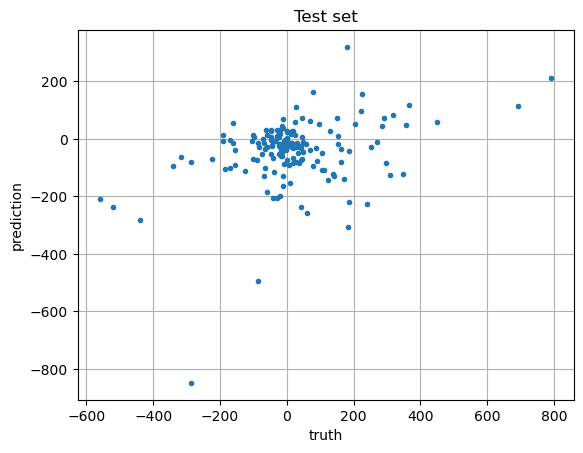

In [91]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(y, out, '.')
ax.grid()
ax.set_xlabel('truth')
ax.set_ylabel('prediction')
ax.set_title('Test set')

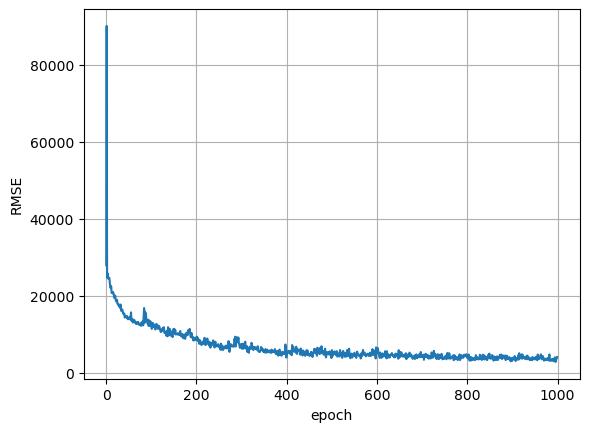

In [92]:
fig, ax = plt.subplots()

ax.plot(loss_list)
ax.set_xlabel('epoch')
ax.set_ylabel('RMSE')
ax.grid()